In [6]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, PassiveAggressiveRegressor, TheilSenRegressor
from sklearn.multioutput import MultiOutputRegressor

#from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [8]:
data_train_prepared = pd.read_csv("../processed_data/data_train_prepared.csv", index_col=0, parse_dates=[0]).asfreq('h')
y_train = pd.read_csv("../processed_data/y_train.csv", index_col=0, parse_dates=[0]).asfreq('h')
data_test_prepared = pd.read_csv("../processed_data/data_test_prepared.csv", index_col=0, parse_dates=[0]).asfreq('h')
y_test = pd.read_csv("../processed_data/y_test.csv", index_col=0, parse_dates=[0]).asfreq('h')

final_test = pd.read_csv("../data/test.csv", index_col=0)

In [34]:
# Only take 10% of the dataset to model faster and already check which model works best

fraction = 0.1
data_train_prepared_sampled = data_train_prepared.sample(frac=fraction, random_state=42)
data_test_prepared_sampled = data_test_prepared.sample(frac=fraction, random_state=42)
y_train_sampled = y_train.sample(frac=fraction, random_state=42)
y_test_sampled = y_test.sample(frac=fraction, random_state=42)

In [4]:
# List of regression model descriptions for plotting

regression_descriptions = [
    'Linear Regression',
    'Ridge Regression',
    'Lasso Regression',
    'ElasticNet Regression',
    'Random Forest Regressor',
    'AdaBoost Regressor',
    'XGBoost Regressor',
    'CatBoost Regressor',
    'Bayesian Ridge',
    'Huber Regressor',
    'Passive Aggressive Regressor',
]

regressors = (
    LinearRegression(),
    Ridge(max_iter=300),
    Lasso(max_iter=300),
    ElasticNet(max_iter=300),
    RandomForestRegressor(n_estimators=300),
    MultiOutputRegressor(AdaBoostRegressor(n_estimators=300)),
    MultiOutputRegressor(XGBRegressor(n_estimators=300)),
    MultiOutputRegressor(CatBoostRegressor(silent=True)),
    MultiOutputRegressor(BayesianRidge(max_iter=300)),
    MultiOutputRegressor(HuberRegressor(max_iter=2000)),
    MultiOutputRegressor(PassiveAggressiveRegressor(max_iter=300)),
)

### Running with classical cross-validation

In [5]:
# Variables
rand_seed = 42
sample_size = 10000
repetitions = 5

cv_folds = 3
scoring_func = make_scorer(mean_absolute_error)
scoring_func_name = "MAE"

In [6]:
classifier_data = pd.DataFrame([
    {'Regressor': None,
     'Sample size': None,
     'CV folds': None,
     'Raw scores': None,
     'Mean {} score'.format(scoring_func_name): None,
     '{} score SD'.format(scoring_func_name): None,
     'Run time (min.)': None}
] * len(regression_descriptions))    # Create 15 empty rows to use for regressor metrics


ind = 0 # Initialize index to append scores to the dataframe

# Loop over regressors
for regressor, description in zip(regressors, regression_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        
        start = time()

        # Cross validate regressor, tracking memory usage
        cross_val_scores = cross_val_score(
            estimator=regressor, 
            X=data_train_prepared_sampled,
            y=y_train_sampled, 
            cv=cv_folds, 
            scoring=scoring_func,
        )

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
    

    mean_score = np.round(np.mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)

    
    # Store run results in dataframe

    classifier_data.iloc[ind] = pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        dT
    ], index=classifier_data.columns)
    
    ind += 1
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data = classifier_data.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=True)

Finished Linear Regression, mean score: 2.202
Finished Ridge Regression, mean score: 2.213
Finished Lasso Regression, mean score: 5.991
Finished ElasticNet Regression, mean score: 7.985
Finished Random Forest Regressor, mean score: 2.314
Finished AdaBoost Regressor, mean score: 5.638
Finished XGBoost Regressor, mean score: 2.158
Finished CatBoost Regressor, mean score: 2.002
Finished Bayesian Ridge, mean score: 2.202
Finished Huber Regressor, mean score: 2.169
Finished Passive Aggressive Regressor, mean score: 3.47
Finished Theil-Sen Regressor, mean score: 2.222


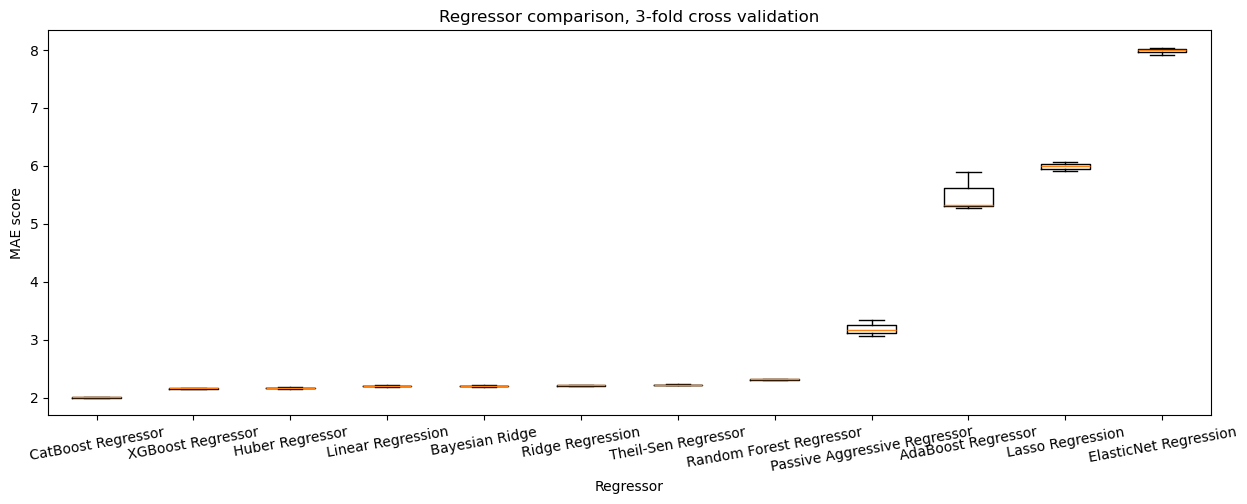

In [9]:
# Plot comparison of regressors using mean score
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Regressor'])
plt.xlabel('Regressor')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Regressor comparison, 3-fold cross validation')
plt.xticks(rotation=10)

plt.savefig("all_models_performance", dpi=200)

plt.show()

In [8]:
classifier_data.drop('Raw scores', axis=1)

,Regressor,Sample size,CV folds,Mean MAE score,MAE score SD,Run time (min.)
7,CatBoost Regressor,10000,3,2.002,0.0028,1.91
6,XGBoost Regressor,10000,3,2.158,0.007,0.25
9,Huber Regressor,10000,3,2.169,0.0083,2.82
0,Linear Regression,10000,3,2.202,0.0088,0.0
8,Bayesian Ridge,10000,3,2.202,0.0088,0.01
1,Ridge Regression,10000,3,2.213,0.0069,0.0
11,Theil-Sen Regressor,10000,3,2.222,0.0083,6.01
4,Random Forest Regressor,10000,3,2.314,0.005,11.18
10,Passive Aggressive Regressor,10000,3,3.47,0.4544,0.03
5,AdaBoost Regressor,10000,3,5.638,0.1919,3.62


CatBoost seems to be the best model for our use case, when using classical cross-validation

### Running with TimeSeriesSplit cross-validation

In [12]:
# Variables
rand_seed = 42
sample_size = 10000
repetitions = 5

cv_folds = TimeSeriesSplit(n_splits=5)
scoring_func = make_scorer(mean_absolute_error)
scoring_func_name = "MAE"

In [13]:
classifier_data2 = pd.DataFrame([
    {'Regressor': None,
     'Sample size': None,
     'CV folds': None,
     'Raw scores': None,
     'Mean {} score'.format(scoring_func_name): None,
     '{} score SD'.format(scoring_func_name): None,
     'Run time (min.)': None}
] * len(regression_descriptions))    # Create 15 empty rows to use for regressor metrics


ind = 0 # Initialize index to append scores to the dataframe

# Loop over regressors
for regressor, description in zip(regressors, regression_descriptions):
    
    dTs = []
    max_mems = []
    raw_scores = []
    
    for i in range(repetitions):
        
        
        start = time()

        # Cross validate regressor, tracking memory usage
        cross_val_scores = cross_val_score(
            estimator=regressor, 
            X=data_train_prepared_sampled,
            y=y_train_sampled, 
            cv=cv_folds, 
            scoring=scoring_func,
        )

        dT = np.round(((time() - start)/60), 2)
        dTs.append(dT)
        raw_scores = np.concatenate((raw_scores, cross_val_scores))
    

    mean_score = np.round(np.mean(raw_scores), 3)
    sd_score = np.round(np.std(raw_scores), 4)

    
    # Store run results in dataframe

    classifier_data2.iloc[ind] = pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        dT
    ], index=classifier_data2.columns)
    
    ind += 1
    
    print(f'Finished {description}, mean score: {mean_score}')

# Sort results by score
classifier_data2 = classifier_data2.sort_values(['Mean {} score'.format(scoring_func_name)], ascending=True)

Finished Linear Regression, mean score: 1130507739.167
Finished Ridge Regression, mean score: 2.526
Finished Lasso Regression, mean score: 5.975
Finished ElasticNet Regression, mean score: 7.947
Finished Random Forest Regressor, mean score: 2.772
Finished AdaBoost Regressor, mean score: 3.514
Finished XGBoost Regressor, mean score: 2.471
Finished CatBoost Regressor, mean score: 2.282
Finished Bayesian Ridge, mean score: 2.273
Finished Huber Regressor, mean score: 2.197
Finished Passive Aggressive Regressor, mean score: 3.424
Finished Theil-Sen Regressor, mean score: 2.284


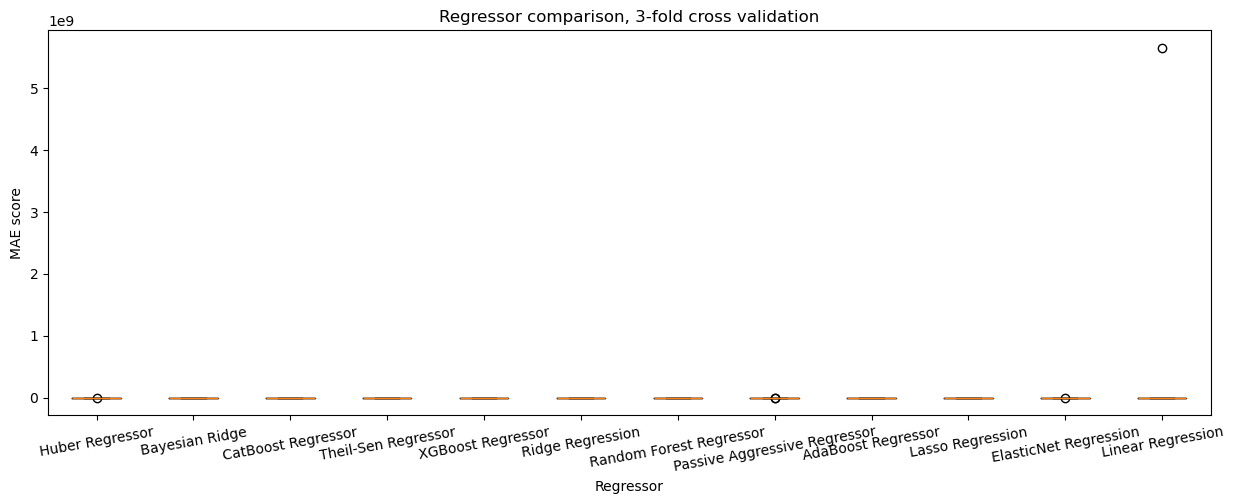

In [14]:
# Plot comparison of regressors using mean score
fig = plt.figure(1, figsize=(15, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data2['Raw scores'])
ax.set_xticklabels(classifier_data2['Regressor'])
plt.xlabel('Regressor')
plt.ylabel('{} score'.format(scoring_func_name))
plt.title('Regressor comparison, 3-fold cross validation')
plt.xticks(rotation=10)

plt.savefig("all_models_performance2", dpi=200)

plt.show()

In [15]:
classifier_data2.drop('Raw scores', axis=1)

,Regressor,Sample size,CV folds,Mean MAE score,MAE score SD,Run time (min.)
9,Huber Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.197,0.0947,0.19
8,Bayesian Ridge,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.273,0.1236,0.01
7,CatBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.282,0.1535,1.55
11,Theil-Sen Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.284,0.1216,7.03
6,XGBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.471,0.1121,0.26
1,Ridge Regression,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.526,0.2332,0.0
4,Random Forest Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",2.772,0.1735,0.62
10,Passive Aggressive Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",3.424,0.3851,0.0
5,AdaBoost Regressor,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",3.514,0.1783,0.49
2,Lasso Regression,10000,"TimeSeriesSplit(gap=0, max_train_size=None, n_...",5.975,0.1112,0.0


# Predictions

## With basic CatBoost

In [16]:
catboost = MultiOutputRegressor(CatBoostRegressor(silent=True))

catboost.fit(data_train_prepared, y_train)

prediction_cat = catboost.predict(data_test_prepared)
prediction_cat[prediction_cat < 0] = 0
rmse_test_cat = mean_absolute_error(prediction_cat, y_test)**0.5
rmse_train_cat = mean_absolute_error(catboost.predict(data_train_prepared), y_train)**0.5

print(f'The train mae is {rmse_train_cat} and the test mae is {rmse_test_cat}.')

The train rmse is 1.297260121355796 and the test rmse is 1.3944469983594345.


In [24]:
path_test = "../data/test.csv"
test = pd.read_csv(path_test)
test["id"] = pd.to_datetime(test["id"])

final_pred_cat = catboost.predict(test)
final_pred_cat[final_pred_cat < 0] = 0

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name cat__year_2020 (found id).

In [19]:
final_pred_cat.to_csv("../output/predictions_cat.csv")

AttributeError: 'numpy.ndarray' object has no attribute 'write_csv'

## With basic Huber

In [17]:
huber = MultiOutputRegressor(HuberRegressor(max_iter=2000))

huber.fit(data_train_prepared, y_train)

prediction_huber = huber.predict(data_test_prepared)
prediction_huber[prediction_huber < 0] = 0
rmse_test_huber = mean_absolute_error(prediction_huber, y_test)**0.5
rmse_train_huber = mean_absolute_error(huber.predict(data_train_prepared), y_train)**0.5

print(f'The train mae is {rmse_train_huber} and the test mae is {rmse_test_huber}.')

The train mae is 1.471099673752445 and the test mae is 1.460540525434569.


In [ ]:
prediction_huber.to_csv("../output/predictions_huber.csv")

## With skforecast

In [26]:
forecasters = {}
for col in y_train.columns:
    forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123),
        lags      = 6)
    forecaster.fit(y=y_train[col], exog=data_train_prepared)
    forecasters[col] = forecaster

In [27]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['cat__year_2020', 'cat__year_2021', 'cat__year_2022', 'cat__year_2023', 'cat__year_2024', 'cat__holiday_0', 'cat__holiday_1', 'cat__rush_hour_0', 'cat__rush_hour_1', 'cat__lockdown_0', 'cat__lockdown_1', 'cat__curfew_0', 'cat__curfew_1', 'num__weekend', 'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1', 'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1', 'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2', 'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2', 'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3', 'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3', 'num__flow', 'num__occupation_rate', 'num__ALTI', 'num__RR1', 'num__QRR1', 'num__T', 'num__QT', 'num__TN', 'n

In [37]:
steps = 2520
predictions = forecaster.predict(steps=steps, exog=data_test_prepared)

In [45]:
final_pred_cat = pd.DataFrame(np.array(predictions).reshape(504, 5), columns=['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'])
final_pred_cat.index = final_test.index
final_pred_cat

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
id,,,,,
2024-09-03 23,5.467498,5.603025,5.824479,6.075848,6.219339
2024-09-04 00,6.369899,7.124723,8.232538,9.571714,10.065667
2024-09-04 01,9.523861,8.811871,7.990769,7.289413,6.765058
2024-09-04 02,6.118032,6.197222,6.061545,5.666000,6.448000
2024-09-04 03,7.530210,7.503000,7.586769,7.846000,7.886000
...,...,...,...,...,...
2024-09-24 18,6.976000,6.964636,6.586182,5.833182,5.490000
2024-09-24 19,5.590500,5.961091,5.826000,5.799727,5.606000
2024-09-24 20,5.740364,5.630750,5.390333,5.351333,5.309333


In [46]:
final_pred_cat.to_csv("../output/submission.csv")

In [10]:
y_train

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
date,,,,,
2020-01-01 00:00:00,42.9,0.7180,15.7,73.1,64.4
2020-01-01 01:00:00,33.6,0.5870,10.1,74.8,66.0
2020-01-01 02:00:00,29.3,0.4165,5.1,51.0,44.9
2020-01-01 03:00:00,30.5,0.2460,7.2,27.7,25.1
2020-01-01 04:00:00,29.3,0.2040,8.3,15.3,13.6
...,...,...,...,...,...
2024-02-11 19:00:00,20.4,0.2080,47.6,11.7,8.5
2024-02-11 20:00:00,14.2,0.2050,49.7,9.4,7.2
2024-02-11 21:00:00,14.4,0.2030,47.7,8.1,5.3


In [11]:
data_train_prepared.columns

Index(['cat__year_2020', 'cat__year_2021', 'cat__year_2022', 'cat__year_2023',
       'cat__year_2024', 'cat__holiday_0', 'cat__holiday_1',
       'cat__rush_hour_0', 'cat__rush_hour_1', 'cat__lockdown_0',
       'cat__lockdown_1', 'cat__curfew_0', 'cat__curfew_1', 'num__weekend',
       'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
       'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
       'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
       'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
       'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
       'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3', 'num__ALTI',
       'num__RR1', 'num__QRR1', 'num__T', 'num__QT', 'num__TN', 'num__QTN',
       'num__QHTN', 'num__TX', 'num__QTX', 'num__QHTX', 'num__DG', 'num__QDG',
       'dates__weekday_sin', 'dates__weekday_cos', 'dates__month_sin',
       'dates__month_cos', 'dates__hour_sin', 'dates__hour_cos',
       'date

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
def tune_xgboost_hyperparameters(X_train, y_train, param_grid=None, cv=5):
    if param_grid is None:
        # Default parameter grid if none provided
        param_grid = {
            "n_estimators": [500, 1000],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [5, 7],
        }

    # Create pipeline with preprocessor and model
    model = XGBRegressor()

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        model, param_grid=param_grid, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Return the best model and parameters
    return grid_search.best_estimator_, grid_search.best_params_


model, params = tune_xgboost_hyperparameters(data_train_prepared, y_train)

In [164]:
final_test_processed = pd.read_csv("../processed_data/final_test.csv", index_col=0)

In [165]:
def rename_lag_columns(df):
    column_mapping = {
        'num__valeur_NO2_lag12': 'num__valeur_NO2_lag2',
        'num__valeur_CO_lag12': 'num__valeur_CO_lag2',
        'num__valeur_O3_lag12': 'num__valeur_O3_lag2',
        'num__valeur_PM10_lag12': 'num__valeur_PM10_lag2',
        'num__valeur_PM25_lag12': 'num__valeur_PM25_lag2',
        'num__valeur_NO2_lag24': 'num__valeur_NO2_lag3',
        'num__valeur_CO_lag24': 'num__valeur_CO_lag3',
        'num__valeur_O3_lag24': 'num__valeur_O3_lag3',
        'num__valeur_PM10_lag24': 'num__valeur_PM10_lag3',
        'num__valeur_PM25_lag24': 'num__valeur_PM25_lag3'
    }
    
    # Rename columns
    df = df.rename(columns=column_mapping)
    return df

# Example usage
final_test_processed = rename_lag_columns(final_test_processed)

In [142]:
c = pd.read_csv("daje.csv").drop(columns="Unnamed: 0")

In [166]:
final_test_processed[['num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
       'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
       'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
       'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
       'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
       'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3']]

,num__valeur_NO2_lag1,num__valeur_CO_lag1,num__valeur_O3_lag1,num__valeur_PM10_lag1,num__valeur_PM25_lag1,num__valeur_NO2_lag2,num__valeur_CO_lag2,num__valeur_O3_lag2,num__valeur_PM10_lag2,num__valeur_PM25_lag2,num__valeur_NO2_lag3,num__valeur_CO_lag3,num__valeur_O3_lag3,num__valeur_PM10_lag3,num__valeur_PM25_lag3
date,,,,,,,,,,,,,,,
2024-09-03 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-04 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-04 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-04 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-24 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-09-24 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
final_test_processed.loc["2024-09-03 23:00:00", [
    'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
    'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
    'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
    'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
    'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
    'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3'
]] = c.loc[0, [
    'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
    'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
    'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
    'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
    'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
    'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3'
]].values


In [167]:
# Define the specific index where the first row of `final_test_processed` is located
first_index = final_test_processed.index[0]  # Replace with the actual first index if known

# Extract the last three rows of `y_test`
last_three_rows = y_test[-3:]

# Assign lagged values to the specified row of `final_test_processed`
for col in last_three_rows.columns:
    final_test_processed.at[first_index, f'num__{col}_lag3'] = last_three_rows.iloc[0][col]  # 3rd last row as lag3
    final_test_processed.at[first_index, f'num__{col}_lag2'] = last_three_rows.iloc[1][col]  # 2nd last row as lag2
    final_test_processed.at[first_index, f'num__{col}_lag1'] = last_three_rows.iloc[2][col]  # Last row as lag1


In [170]:
final_test_processed.columns

Index(['cat__year_2024', 'cat__holiday_0', 'cat__rush_hour_0',
       'cat__rush_hour_1', 'cat__lockdown_0', 'cat__curfew_0', 'num__weekend',
       'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
       'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
       'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
       'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
       'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
       'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3', 'num__flow',
       'num__occupation_rate', 'num__ALTI', 'num__RR1', 'num__QRR1', 'num__T',
       'num__QT', 'num__TN', 'num__QTN', 'num__QHTN', 'num__TX', 'num__QTX',
       'num__QHTX', 'num__DG', 'num__QDG', 'dates__weekday_sin',
       'dates__weekday_cos', 'dates__month_sin', 'dates__month_cos',
       'dates__hour_sin', 'dates__hour_cos', 'dates__day_sin',
       'dates__day_cos', 'cat__curfew_1', 'cat__holiday_1', 'cat__lockdown_1',
       'cat

In [247]:
import pandas as pd

def recursive_forecast(df, model, target_columns, lags=3, forecast_steps=504):
    # Initialize predictions dictionary
    predictions = {col: [] for col in target_columns}  # Store predictions for each target

    # Get a list of indices to ensure sequential row access by index
    indices = df.index.tolist()
    
    for step in range(forecast_steps):
        # Get the current row based on the index
        current_index = indices[step]
        latest_row = df.loc[current_index].copy()  # Copy to avoid modifying df directly
        
        # Prepare current input by selecting lagged features and other relevant columns
        X_current = pd.DataFrame([latest_row])  # Single-row DataFrame with current features

        X_current[[
    'num__valeur_NO2_lag1',
    'num__valeur_NO2_lag2', 
    'num__valeur_NO2_lag3',
]] = (X_current[[
    'num__valeur_NO2_lag1',
    'num__valeur_NO2_lag2', 
    'num__valeur_NO2_lag3',
]] - 1.9)/ (131- 1.9)
        
        X_current[[
    'num__valeur_CO_lag1',
    'num__valeur_CO_lag2', 
    'num__valeur_CO_lag3',
]] =  (X_current[[
    'num__valeur_CO_lag1',
    'num__valeur_CO_lag2', 
    'num__valeur_CO_lag3',
]] - 0.037)/ (4.309- 0.037)
        
        X_current[[
    'num__valeur_O3_lag1',
    'num__valeur_O3_lag2', 
    'num__valeur_O3_lag3',
]] /= 193
        
        X_current[[
    'num__valeur_PM10_lag1',
    'num__valeur_PM10_lag2', 
    'num__valeur_PM10_lag3',
]] = (X_current[[
    'num__valeur_PM10_lag1',
    'num__valeur_PM10_lag2', 
    'num__valeur_PM10_lag3',
]] - 0.5)/ 128
        
        X_current[[
    'num__valeur_PM25_lag1',
    'num__valeur_PM25_lag2', 
    'num__valeur_PM25_lag3',
]] /= 111.1
        

    
        # Predict all target variables at once
        forecast_values = model.predict(X_current)[0] # Assuming model outputs a single array of predictions


        # Store the predictions for this step
        for idx, target in enumerate(target_columns):
            predictions[target].append(forecast_values[idx])

        # Update lagged values in the next row if it exists
        if step < len(indices) - 1:  # Check if a next row exists
            next_index = indices[step + 1]  # Find the next date index
            index = indices[step]
            for idx, target in enumerate(target_columns):
                # Shift lagged values backwards in the next row
                
                df.at[next_index, f'num__{target}_lag2'] = df.at[index, f'num__{target}_lag1']
                df.at[next_index, f'num__{target}_lag3'] = df.at[index, f'num__{target}_lag2']
                # Set the latest forecast as lag1 in the next row
                df.at[next_index, f'num__{target}_lag1'] = forecast_values[idx]

    return predictions

# Example usage
target_columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]
predictions = recursive_forecast(final_test_processed, model, target_columns, forecast_steps=504)





In [248]:
final_test_processed[["num__valeur_CO_lag1","num__valeur_CO_lag2","num__valeur_CO_lag3"]]

,num__valeur_CO_lag1,num__valeur_CO_lag2,num__valeur_CO_lag3
date,,,
2024-09-03 23:00:00,0.184000,0.225000,0.234000
2024-09-04 00:00:00,0.181054,0.184000,0.225000
2024-09-04 01:00:00,0.175675,0.181054,0.184000
2024-09-04 02:00:00,0.169737,0.175675,0.181054
2024-09-04 03:00:00,0.163964,0.169737,0.175675
...,...,...,...
2024-09-24 18:00:00,0.235560,0.222882,0.212026
2024-09-24 19:00:00,0.249467,0.235560,0.222882
2024-09-24 20:00:00,0.253037,0.249467,0.235560


In [246]:
yess

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
id,,,,,
2024-09-03 23,20.825024,0.181054,39.337906,8.219090,4.734635
2024-09-04 00,20.005255,0.181149,37.744049,8.700358,4.338078
2024-09-04 01,20.048035,0.179097,37.764191,9.419273,4.084607
2024-09-04 02,19.789213,0.176585,37.083401,9.984299,3.847523
2024-09-04 03,20.796043,0.174133,35.103294,9.707127,3.923559
...,...,...,...,...,...
2024-09-24 18,43.126720,2.259347,28.099043,15.761927,3.812470
2024-09-24 19,42.023594,2.212849,25.850510,16.690977,3.918416
2024-09-24 20,38.392506,1.575099,25.539291,16.626701,3.718701


In [108]:
final_test_processed.shape

(504, 50)

In [182]:
final_test_processed.index

Index(['2024-09-03 23:00:00', '2024-09-04 00:00:00', '2024-09-04 01:00:00',
       '2024-09-04 02:00:00', '2024-09-04 03:00:00', '2024-09-04 04:00:00',
       '2024-09-04 05:00:00', '2024-09-04 06:00:00', '2024-09-04 07:00:00',
       '2024-09-04 08:00:00',
       ...
       '2024-09-24 13:00:00', '2024-09-24 14:00:00', '2024-09-24 15:00:00',
       '2024-09-24 16:00:00', '2024-09-24 17:00:00', '2024-09-24 18:00:00',
       '2024-09-24 19:00:00', '2024-09-24 20:00:00', '2024-09-24 21:00:00',
       '2024-09-24 22:00:00'],
      dtype='object', name='date', length=504)

In [249]:
yes = pd.DataFrame(predictions)

In [250]:
yess = yes.set_index(final_test_processed.index)

In [251]:
# Convert index to string, remove last 6 characters, and set it back
yess.index.name = "id"
yess.index = yess.index.astype(str).str[:-6] # Use int if needed; otherwise, omit `.astype(int)`



In [252]:
yess

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
id,,,,,
2024-09-03 23,20.825024,0.181054,39.337906,8.219090,4.734635
2024-09-04 00,18.189514,0.175675,40.029743,8.095816,4.611012
2024-09-04 01,16.007454,0.169737,40.949696,7.750938,4.527845
2024-09-04 02,14.194432,0.163964,41.927109,7.795516,4.525877
2024-09-04 03,14.654327,0.160304,41.275864,7.947597,4.622379
...,...,...,...,...,...
2024-09-24 18,44.851879,0.249467,39.686340,17.890074,12.959746
2024-09-24 19,43.784153,0.253037,36.638016,18.796316,14.111523
2024-09-24 20,41.472301,0.250171,36.130096,18.612751,14.037618


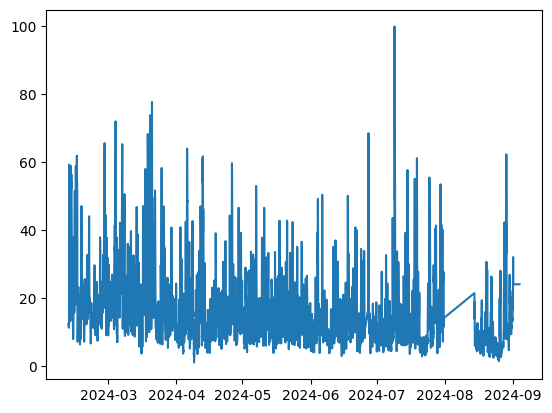

In [257]:
plt.plot(y_test["valeur_NO2"])

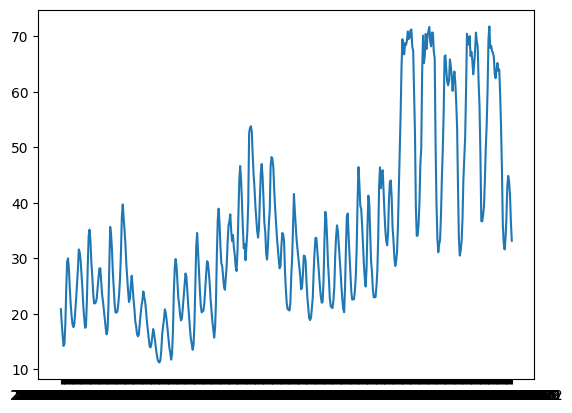

In [256]:
import matplotlib.pyplot as plt
plt.plot(yess["valeur_NO2"])

In [254]:
yess.to_csv("yes.csv")

In [163]:
c

,num__valeur_NO2_lag1,num__valeur_CO_lag1,num__valeur_O3_lag1,num__valeur_PM10_lag1,num__valeur_PM25_lag1,num__valeur_NO2_lag2,num__valeur_CO_lag2,num__valeur_O3_lag2,num__valeur_PM10_lag2,num__valeur_PM25_lag2,num__valeur_NO2_lag3,num__valeur_CO_lag3,num__valeur_O3_lag3,num__valeur_PM10_lag3,num__valeur_PM25_lag3
0,0.17196,0.03441,0.195236,0.0625,0.041404,0.17196,0.044007,0.134127,0.078906,0.048605,0.17196,0.046114,0.230451,0.092969,0.063906


In [135]:
final_test_processed_prova.to_csv("nada.csv")

In [115]:
y_pred_df

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,9.928885,0.177923,56.784210,11.102319,5.527485
1,11.688843,0.187356,53.609653,11.701147,5.785648
2,11.717370,0.187779,51.317974,12.230932,6.127907
3,11.754715,0.184320,51.753857,12.513878,6.539161
4,17.549822,0.194266,46.861183,13.520401,6.365506
...,...,...,...,...,...
4914,27.768663,0.216262,55.845158,14.281153,5.863310
4915,25.826973,0.226294,50.050114,12.752861,6.282967
4916,23.653542,0.239100,46.812534,13.069373,7.232729
4917,22.598768,0.227920,44.384861,11.804344,6.658209


In [172]:
final_test_processed=final_test_processed.drop(columns=["num__flow", "num__occupation_rate"])

In [239]:
y_test

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
date,,,,,
2024-02-12 00:00:00,12.5,0.193,53.2,12.1,5.9
2024-02-12 01:00:00,12.6,0.192,51.0,12.7,6.3
2024-02-12 02:00:00,11.3,0.187,52.3,12.5,6.5
2024-02-12 03:00:00,13.6,0.192,51.6,12.9,6.4
2024-02-12 04:00:00,14.0,0.196,51.5,12.3,6.3
...,...,...,...,...,...
2024-09-03 18:00:00,24.1,0.222,55.1,12.0,5.3
2024-09-03 19:00:00,24.1,0.245,48.2,13.4,7.0
2024-09-03 20:00:00,24.1,0.234,44.5,12.4,7.1


In [238]:
yess

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
id,,,,,
2024-09-03 23,20.825024,0.181054,39.337906,8.219090,4.734635
2024-09-04 00,20.005255,0.181149,37.744049,8.700358,4.338078
2024-09-04 01,20.048035,0.179097,37.764191,9.419273,4.084607
2024-09-04 02,19.789213,0.176585,37.083401,9.984299,3.847523
2024-09-04 03,20.796043,0.174133,35.103294,9.707127,3.923559
...,...,...,...,...,...
2024-09-24 18,43.126720,2.259347,28.099043,15.761927,3.812470
2024-09-24 19,42.023594,2.212849,25.850510,16.690977,3.918416
2024-09-24 20,38.392506,1.575099,25.539291,16.626701,3.718701


In [176]:
# Reorder `final_test_processed` columns to match `data_test_prepared` column order
final_test_processed = final_test_processed[data_test_prepared.columns]


In [79]:
data_test_prepared.columns

Index(['cat__year_2020', 'cat__year_2021', 'cat__year_2022', 'cat__year_2023',
       'cat__year_2024', 'cat__holiday_0', 'cat__holiday_1',
       'cat__rush_hour_0', 'cat__rush_hour_1', 'cat__lockdown_0',
       'cat__lockdown_1', 'cat__curfew_0', 'cat__curfew_1', 'num__weekend',
       'num__valeur_NO2_lag1', 'num__valeur_CO_lag1', 'num__valeur_O3_lag1',
       'num__valeur_PM10_lag1', 'num__valeur_PM25_lag1',
       'num__valeur_NO2_lag2', 'num__valeur_CO_lag2', 'num__valeur_O3_lag2',
       'num__valeur_PM10_lag2', 'num__valeur_PM25_lag2',
       'num__valeur_NO2_lag3', 'num__valeur_CO_lag3', 'num__valeur_O3_lag3',
       'num__valeur_PM10_lag3', 'num__valeur_PM25_lag3', 'num__ALTI',
       'num__RR1', 'num__QRR1', 'num__T', 'num__QT', 'num__TN', 'num__QTN',
       'num__QHTN', 'num__TX', 'num__QTX', 'num__QHTX', 'num__DG', 'num__QDG',
       'dates__weekday_sin', 'dates__weekday_cos', 'dates__month_sin',
       'dates__month_cos', 'dates__hour_sin', 'dates__hour_cos',
       'date

In [23]:
y_pred = model.predict(data_test_prepared)

In [25]:
y_test

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
date,,,,,
2024-02-12 00:00:00,12.5,0.193,53.2,12.1,5.9
2024-02-12 01:00:00,12.6,0.192,51.0,12.7,6.3
2024-02-12 02:00:00,11.3,0.187,52.3,12.5,6.5
2024-02-12 03:00:00,13.6,0.192,51.6,12.9,6.4
2024-02-12 04:00:00,14.0,0.196,51.5,12.3,6.3
...,...,...,...,...,...
2024-09-03 18:00:00,24.1,0.222,55.1,12.0,5.3
2024-09-03 19:00:00,24.1,0.245,48.2,13.4,7.0
2024-09-03 20:00:00,24.1,0.234,44.5,12.4,7.1


In [27]:
y_pred_df = pd.DataFrame(columns=y_test.columns, data=y_pred)
y_pred_df

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,9.928885,0.177923,56.784210,11.102319,5.527485
1,11.688843,0.187356,53.609653,11.701147,5.785648
2,11.717370,0.187779,51.317974,12.230932,6.127907
3,11.754715,0.184320,51.753857,12.513878,6.539161
4,17.549822,0.194266,46.861183,13.520401,6.365506
...,...,...,...,...,...
4914,27.768663,0.216262,55.845158,14.281153,5.863310
4915,25.826973,0.226294,50.050114,12.752861,6.282967
4916,23.653542,0.239100,46.812534,13.069373,7.232729
4917,22.598768,0.227920,44.384861,11.804344,6.658209


In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def calculate_average_mae(predictions, actuals, target_columns):
    """
    Calculate the MAE for each pollutant and return the average MAE.

    Parameters:
    - predictions: dict of lists where keys are target columns and values are lists of predicted values
    - actuals: DataFrame containing the actual values of the pollutants
    - target_columns: List of target column names corresponding to pollutants
    
    Returns:
    - average_mae: float, average MAE across the pollutants
    """
    mae_values = []
    
    for target in target_columns:
        # Calculate MAE for each pollutant
        mae = mean_absolute_error(actuals[target], predictions[target])
        mae_values.append(mae)
        print(F"mae for {target} is {mae}")
    
    # Calculate the average MAE
    average_mae = np.mean(mae_values)
    return average_mae

# Example usage
target_columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]
average_mae = calculate_average_mae(y_pred_df, y_test, target_columns)
print("Average MAE:", average_mae)


mae for valeur_NO2 is 2.637602320965481
mae for valeur_CO is 0.015775625894466294
mae for valeur_O3 is 4.356802746237024
mae for valeur_PM10 is 1.547364741296654
mae for valeur_PM25 is 1.063791249252294
Average MAE: 1.924267336729184
